In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pandas as pd
from pprint import pprint

## Utility functions definition:

- `get_customers`: return the number of customers $N$ in the problem 
- `vel`: return the regime velocity given  mass $m$, gradient  $h$, $P_{human}$, $P_{electric}$ in $km/h$
- `time_matrix`: return time matrix $t_{ij}^l$ extended, to be used in Dijkstra shortest path algorithm.
- `extract_min` and `dijkstra`: our shortest path implementation
- `shortest_path_matrix`: retrun time matrix $t_{ij}^l$ for path among customer points

In [2]:
def get_customers(dataframe):
    """
    Given a dataframe from csv instance, return the number of customers.
    Will be used to count how many constumers are in a graph with internal nodes.
    """
    return np.count_nonzero(dataframe["demand"].to_numpy() >= 0)

In [3]:
def vel(m, h, P, P_electric=250):
    ### aer. resistence
    Cd = 1.18
    A = 0.83  # m^2
    rho = 1.18  # kg/m^3

    c_Fd = rho * Cd * A * 0.5

    ### rolling resistance
    Cr = 0.01
    g = 9.81  # m/s^2

    eta = 0.95

    c0 = P * eta
    c1 = m * g * (Cr * np.cos(np.arctan(h)) + np.sin(np.arctan(h)))
    c3 = c_Fd

    v_max = 30  # km/h

    coefs = [c3, 0, c1, -eta * P]
    coefs_electric = [c3, 0, c1, -eta * (P + P_electric)]
    v = np.max(np.real(3.6 * np.roots(coefs)))
    v_electric = np.max(np.real(3.6 * np.roots(coefs_electric)))
    if v > 25:
        return min(v, v_max)
    else:
        return min(v_electric, 25)



In [4]:
def time_matrix(data_matrix, load_levels, P, vehicle_weight=140):
    """
    Given a dataframe from csv instance, a set of load level and a specific power (human power),
    calculates the time travel for each edge of the graph.
    """
    N = len(data_matrix.index)
    n_levels = len(load_levels)
    elevation = data_matrix.elevation.to_numpy()
    d_ij_mat = data_matrix.iloc[:, 8:].to_numpy()  # extract from the dataframe only the distances, from column 8 untill the end
    t_ij_mat = np.zeros((N, N, n_levels))  # size of t_ij: [N X N X n_levels], is a 3D array
    for i in range(N):
        for j in range(N):
            d_ij = d_ij_mat[i, j]
            if i != j and d_ij != 0:
                h = (elevation[j] - elevation[i]) / d_ij  # calculate the slope of the path
                for l in range(n_levels):  # for each load_level
                    m = load_levels[l] + vehicle_weight
                    t_ij_mat[i, j, l] = (60 * d_ij / vel(m, h, P, P_electric=250))  # time travel in minutes
    return t_ij_mat

In [5]:
def extract_min(Q, distance):
    minimo = float("inf")  # highest python value
    nome = ""
    for q in Q:  # find the smallest
        if distance[q] <= minimo:
            nome = q
            minimo = distance[q]
    Q.remove(nome)  # remove the correct node from the que
    return nome  # tell me wich node is removed


def dijkstra(source, weight_matrix, l=0):
    distance = dict()  # dict for distance from source
    parent = dict()  # dict for parentnes of each node
    nodes = np.array(
        [i for i in range(len(weight_matrix))]
    )  # list of current node to iterate
    for node in nodes:
        distance[node] = float("inf")
        parent[node] = None
    distance[source] = 0
    S = []
    Q = {node for node in nodes}  # set used as queue, coupled with distance dict
    while len(Q) > 0:
        u = extract_min(Q, distance)  # extract the min from Q,using distance dict
        S.append(u)  # ultimated nodes
        for v, w in enumerate(weight_matrix[u]):  # for each node v, outgoing from u, with weight w
            if distance[v] > distance[u] + w[l] and w[l] != 0:  # relax phase
                distance[v] = distance[u] + w[l]
                parent[v] = u

    return distance, parent  # return distances from source and each node parent !

In [6]:
def shortest_path_matrix(t_ij_mat, N):
    """
    Given the time travel matrix, calculates the shortest path between al possible pairs of customers, both for extendend and base case.
    N is the number of customers, not the number of nodes.
    """

    load_levels = np.shape(t_ij_mat)[-1]

    sp_matrix = np.empty((N, N, load_levels))

    nodes = np.array([i for i in range(N)])
    levels = np.array([i for i in range(t_ij_mat.shape[-1])])
    for source in nodes:
        for l in levels:
            distance, _t = dijkstra(source, t_ij_mat, l)
            sp_matrix[source, :, l] = list(distance.values())[:N]
    return sp_matrix

## Model implementation

### Problem setup
Load dataframe.
Parameters:
- `.csv` file
- `extended` ,`=1` if internal nodes are included.

**NB** Only synthetic data have intermediate points.

In [7]:
df = pd.read_csv("./instances/small/Fukuoka_01.csv") #in Fukuoka instances there are no intermediate points
#df = pd.read_csv("./instances/synthetic/generated_grid_extended.csv") #generated data have intermediate points
#df = pd.read_csv("./instances/small/Fukuoka_01.csv") # Trieste instance without intermediate points

extended = 0

In [8]:
N = get_customers(df)
N0 = N - 1  # customers
if extended != 1:
    df = df.iloc[:N, : 8 + N] # if no extended network is considered, take first N entries
else:
    df.iloc[:N, 8 : 8 + N] = 0 

Weight categorization in load levels. Parameters:
- `Q_min`
- `Q_max`
- `n_levels`


In [9]:
Q_min = 0  # minum cargo load level
Q_max = 160  # maximum cargo load level
n_levels = 5  # number of load intervals

load_levels = np.array(
    [(0.5 + i) * (Q_max - Q_min) / n_levels for i in range(n_levels)]
)
upper = load_levels + (Q_max - Q_min) / (n_levels * 2)
lower = load_levels - (Q_max - Q_min) / (n_levels * 2)

s = df.s.to_numpy()  # service time
s[0] = 0  # set depot service time to 0

a = df["tw a"].to_numpy()
a[0] = 0  # set depot arrival time to 0

b = df["tw b"].to_numpy()
b[0] = np.sum(b[1:])  # set depot max arrival time such that it is the highest among all customers

demand = df.demand.to_numpy()
demand[0] = 0  # set depot demand to 0

Q = upper[-1]  # set maximum possible cargo weight equal to the upper bound of load levels

Time matrix calculation.
Parameters:
- `P`
- `vehicle_weight`

$M_{ij}$ calculation for constraint $14$. 

In [10]:
t_ij_L = time_matrix(df, load_levels, P=150, vehicle_weight=140)

t_ij = shortest_path_matrix(t_ij_L, N)

M_ij = np.empty((N, N))
for i in range(N):
    for j in range(N):
        M_ij[i, j] = max([0, b[i] + s[i] + t_ij[i, j, -1] - a[j]])

## Gurobi model implementation

In [11]:
model = gp.Model("VRPLTT")

Set parameter Username
Academic license - for non-commercial use only - expires 2022-07-17


<p>



Constraints and decision variables are numbered as per *Fontaine,P.(2022)*.


### Decision variables
- $x_{ij}$ : binary
- $z_{ij}^l$ : binary
- $f_{ij}\geq 0$: continuous
- $y_{i}\geq 0$: continuous

In [12]:
x_ij = model.addVars(
    [(i, j) for i in range(N) for j in range(N)], vtype=GRB.BINARY, name="x_ij"
)  # c16

z_ij = model.addMVar((N, N, n_levels), vtype=GRB.BINARY, name="z_ij")  # c18

y_i = model.addVars([i for i in range(N)], vtype=GRB.CONTINUOUS, lb=0, name="y_i")  #

f_ij = model.addVars(
    [(i, j) for i in range(N) for j in range(N)],
    vtype=GRB.CONTINUOUS,
    lb=0,
    name="f_ij",
)  # c17

### Constraints

$$\sum_{j \in N}x_{ij}=1 \quad \forall i \in N_0$$
$$\sum_{i \in N}x_{ij}=1 \quad \forall j \in N_0$$

In [13]:
c8 = model.addConstrs( gp.quicksum( x_ij[i,j] for j in range(0,N) ) == 1
                                         for i in range(1,N))
c9 = model.addConstrs( gp.quicksum( x_ij[j,i] for j in range(0,N) ) == 1
                                         for i in range(1,N))

$$\sum_{j \in N}f_{ji}-\sum_{j \in N}f_{ij}=q_i \quad \forall i \in N_0$$

In [14]:
c10 = model.addConstrs(
    gp.quicksum(f_ij[j, i] - f_ij[i, j] for j in range(0, N)) == demand[i]
    for i in range(1, N))

$$ q_j x_{ij} \leq f_{ij} \quad \forall(i,j) \in E $$
$$ f_{ij} \leq (Q-q_i)x_{ij}  \quad \forall(i,j) \in E $$

In [15]:
c11_l = model.addConstrs(
    demand[j] * x_ij[i, j] <= f_ij[i, j] for i in range(0, N) for j in range(0, N))

c11_u = model.addConstrs(
    f_ij[i, j] <= (Q - demand[i]) * x_ij[i, j] for i in range(0, N) for j in range(0, N))

$$ \sum_{l \in L} z_{ij}^l = x_{ij} \quad \forall (i,j) \in E $$

In [16]:
c12 = model.addConstrs(
    gp.quicksum(z_ij[i, j, l] for l in range(n_levels)) == x_ij[i, j]
    for i in range(0, N)
    for j in range(0, N))

$$ \sum_{l \in L}p^lz^l_{ij} \leq f_{ij}  \quad \forall (i,j) \in E  $$
$$ f_{ij} \leq \sum_{l \in L} r^l z^l_{ij} \quad \forall (i,j) \in E  $$

In [17]:
c13_l = model.addConstrs(
    lower @ z_ij[i, j, :] <= f_ij[i, j] for i in range(N) for j in range(N))

c13_u = model.addConstrs(
    upper @ z_ij[i, j, :] >= f_ij[i, j] for i in range(N) for j in range(N))

$$y_i-y_j+s_i+\sum_{l \in L} t_{ij}^lz_{ij}^l \leq M_{ij}(1-x_{ij}) \quad \forall i \in N, j \in N_0, i \neq j $$

In [18]:
c14 = model.addConstrs(
    y_i[i] - y_i[j] + s[i] + t_ij[i, j, :] @ z_ij[i, j, :] <= M_ij[i, j] * (1 - x_ij[i, j])
    for i in range(0, N)
    for j in range(1, N)
    if i != j)

$$a_i \leq y_i \quad \forall i \in N_0$$
$$y_i \leq b_i \quad \forall i \in N_0$$

In [19]:
c15_l = model.addConstrs(y_i[i] >= a[i] for i in range(1, N))

c15_u = model.addConstrs(y_i[i] <= b[i] for i in range(1, N))

In [20]:
# c_nostro = model.addConstr(gp.quicksum(f_ij[i,0] for i in range(1,N)) == 0)

$$objective=min\sum_{(i,j)\in E}\sum_{l\in L}t^l_{ij}z^l_{ij}$$ 

In [21]:
obj = model.setObjective(
    gp.quicksum(
        t_ij[i, j, :] @ z_ij[i, j, :] for i in range(0, N) for j in range(0, N)
    ),
    GRB.MINIMIZE,
)

## Model run

In [22]:
model.setParam("Threads", 8)
model.setParam("TimeLimit",3600)

model.optimize()

Set parameter Threads to value 8
Set parameter TimeLimit to value 3600
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (linux64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 2456 rows, 2820 columns and 12765 nonzeros
Model fingerprint: 0xd983338b
Variable types: 420 continuous, 2400 integer (2400 binary)
Coefficient statistics:
  Matrix range     [2e-01, 2e+03]
  Objective range  [3e-01, 9e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e-02, 2e+03]
Presolve removed 817 rows and 969 columns
Presolve time: 0.10s
Presolved: 1639 rows, 1851 columns, 10160 nonzeros
Variable types: 302 continuous, 1549 integer (1549 binary)
Found heuristic solution: objective 531.7809105
Found heuristic solution: objective 326.5819115

Root relaxation: objective 1.524038e+02, 1059 iterations, 0.03 seconds (0.03 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    

## Tour visualization

In [23]:
def visualize_solution(z_ij,x_ij):
    import graphviz as gv
    G = gv.Digraph(comment='vrpltt',strict=True)
    for i in range(N):
        if i!=0:
            G.node(str(i),label=f"Client {i}"+"\n"+f"{demand[i]} kg") 
        else:
            G.node(str(i),label="Depot"+"\n"+f"{demand[i]} kg") 
    for i in range(N):
        for j in range(N):
            if (x_ij[i,j].x>0 and i!=j):
                llevel=0
                for key,value in enumerate(z_ij[i,j,:].x):
                    if value>=0.9:
                        llevel=key
                        break
                G.edge(str(i),str(j),label=f"{round(f_ij[i,j].x,1)} kg"+f" \n{int(y_i[j].x)} min") 
                if j==0:
                    G.edge(str(i),str(j),label=f"{round(f_ij[i,j].x,1)}",color="red")
    display(G)
    #G.render("./graph")

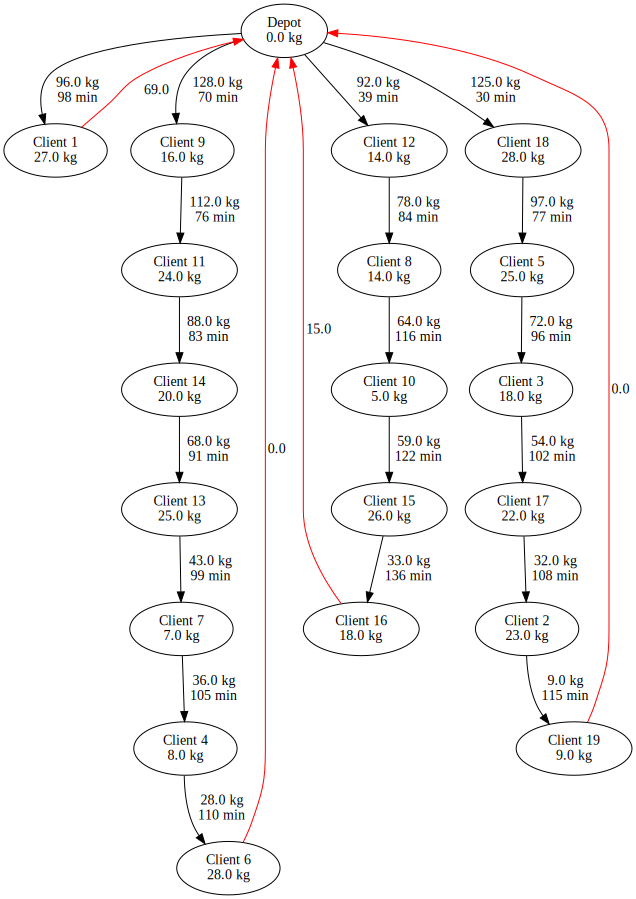

In [24]:
visualize_solution(z_ij,x_ij)

## API tour visualization
- Run with Google Maps API key.

In [25]:
def rgb_to_hex(r, g, b):
    return ('{:X}{:X}{:X}').format(r, g, b)

def get_tour(df,x_ij):
    N=len(df)
    tour=[]
    for j in range(1,N):
        if x_ij[0,j].x > 0.1:
            tour.append(j)
    tour_list=[]
    for i in tour:
        next_node=i
        t=[(0,i)]
        current_node=next_node
        
        while(next_node!=0):
            for j in range(0,N):
                if x_ij[next_node,j].x > 0.1  :
                    t.append((next_node,j))
                    next_node=j
                    break
        tour_list.append(t)
    return tour_list
    

def generate_map(df,x_ij,key,zoom=15):
    height=900
    width=900
    x_center=df.x.mean()
    y_center=df.y.mean()
    path=""
    travel=50
    N=len(df.index)
    tour_list=get_tour(df,x_ij)
    color_hex=0
    color_list=["red","green","blue","yellow","purple","cyan"]
    for tour in tour_list:
        color="0x"+rgb_to_hex(np.random.randint(50,100),np.random.randint(50,100),np.random.randint(50,100))
        for edge in tour:
                if edge[1]==0:
                    travel+=30
                    path+=f"&path=color:black|weight:2|{df.x.iloc[edge[0]]},{df.y.iloc[edge[0]]}|{df.x.iloc[edge[1]]},{df.y.iloc[edge[1]]}"
                else:
                    path+=f"&path=color:{color_list[color_hex]}|weight:3|{df.x.iloc[edge[0]]},{df.y.iloc[edge[0]]}|{df.x.iloc[edge[1]]},{df.y.iloc[edge[1]]}"
        color_hex+=1
    option="&style=element:labels%7Cvisibility:off&style=feature:administrative%7Celement:geometry%7Cvisibility:off&style=feature:administrative.land_parcel%7Cvisibility:off&style=feature:administrative.neighborhood%7Cvisibility:off&style=feature:poi%7Cvisibility:off&style=feature:road%7Celement:labels.icon%7Cvisibility:off&"
    marker=f"&markers=color:blue%7Clabel:{chr(df.index[0]+65)}%7C{df.x.iloc[0]},{df.y.iloc[0]}"
    for i in df.index[1:]:
            marker+=f"&markers=color:red%7Clabel:{chr(df.index[i]+65)}%7C{df.x.iloc[i]},{df.y.iloc[i]}"  
            
    return f"https://maps.googleapis.com/maps/api/staticmap?center={x_center}%2c{y_center}&zoom={zoom}&size={height}x{width}&maptype=roadmap{marker}{option}{path}&key={key}"


In [26]:
key=''
if key=='':
    print("Use API key provided in private files")
else:
    print(generate_map(df,x_ij,key=key))

Use API key provided in private files
